In [55]:
import fastai
from fastai import *
from fastai.text import *
from fastai.core import *
fastai.__version__

'1.0.61'

In [56]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import os

In [57]:
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1YqX9NIXlEsHwq0WI4Y-MmnQvneg8NEEy')

In [58]:
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1EaQiJQlQaajP00wP4PQXOQmu8gzoPuRz')

In [5]:
train_df['description'] = train_df['description'].str.lower()
test_df['description'] = test_df['description'].str.lower()

In [6]:
# split data into training and validation set
df_trn, df_val = train_test_split(train_df[['genre','description']], stratify = train_df['genre'], 
                                  test_size = 0.05, random_state = 42)
df_trn.shape, df_val.shape

((9500, 2), (500, 2))

In [59]:
df_trn.head()

,genre,description
2844,drama,"a story about two brothers, gopi who is a far..."
2893,drama,a man in a gleaming white suit comes to a sma...
1011,documentary,"recorded in occupied palestine, uprooted expl..."
7279,drama,when malaysian exchange students julia and am...
4530,short,this short shows how gossip can be used to sp...


In [60]:
# Language model data
data_lm = TextLMDataBunch.from_df('.', train_df=df_trn, valid_df=df_val)
data_lm.save('tmp_lm.pkl')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.00E-02


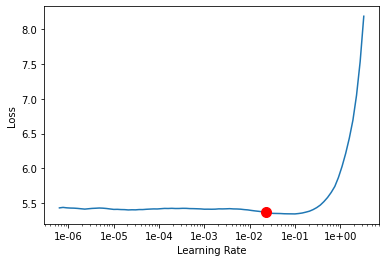

In [61]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [62]:
learn.unfreeze()
learn.fit_one_cycle(2,1e-2,moms=(0.8,0.7))
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.953106,4.627264,0.245089,01:18
1,4.377767,4.409633,0.263600,01:17


In [63]:
learn.save_encoder('finetuned_enc')

In [64]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = '.', train_df=df_trn, valid_df=df_val, test_df=test_df,
                                      text_cols='description', label_cols='genre',
                                      vocab=data_lm.vocab, bs=64, shuffle = False,)
data_clas.save('tmp_DB.pkl')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [65]:
data_clas

TextClasDataBunch;

Train: LabelList (9500 items)
x: TextList
xxbos a story about two brothers , gopi who is a farmer and dinesh , a college student . gopi 's hopes for his younger brother are dashed when dinesh joins campus politics and a world of violence . things start to fall apart when gopi , a hindu marries sainaba , a muslim girl against her family 's wishes . the intense political rivalry between sainaba 's brother and dinesh brings matters to a boiling point after the marriage .,xxbos a man in a xxunk white suit comes to a small southern town on the eve of integration . his name is adam cramer . he calls himself a social reformer . but his aim is to incite the people against letting black children into the town 's white school . soon he has the white citizens of the town worked up . he thinks he 's leading them ; but a man he befriends and immediately betrays knows better . the people have become a mob . the black leader of a church and a white newspaper editor soon feel its w

In [66]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('finetuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9500 items)
x: TextList
xxbos a story about two brothers , gopi who is a farmer and dinesh , a college student . gopi 's hopes for his younger brother are dashed when dinesh joins campus politics and a world of violence . things start to fall apart when gopi , a hindu marries sainaba , a muslim girl against her family 's wishes . the intense political rivalry between sainaba 's brother and dinesh brings matters to a boiling point after the marriage .,xxbos a man in a xxunk white suit comes to a small southern town on the eve of integration . his name is adam cramer . he calls himself a social reformer . but his aim is to incite the people against letting black children into the town 's white school . soon he has the white citizens of the town worked up . he thinks he 's leading them ; but a man he befriends and immediately betrays knows better . the people have become a mob . the black leader of a church and a white newspaper editor

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


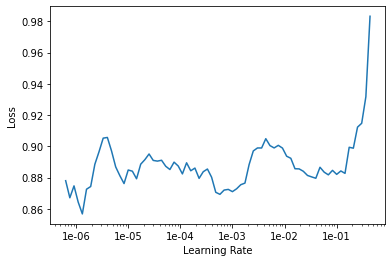

In [70]:
learn.lr_find()
learn.recorder.plot()


In [68]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
learn.save('step-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.944428,0.880327,0.636000,00:26


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


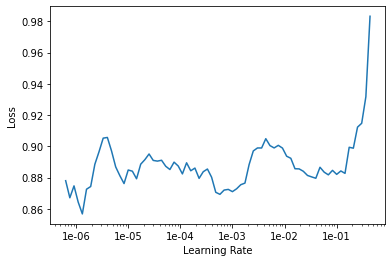

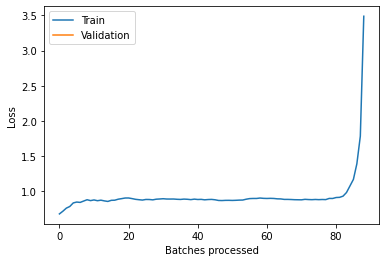

In [71]:
learn.recorder.plot()
learn.recorder.plot_losses()

In [42]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/2.6**4, 1e-5),moms=(0.8,0.7))
learn.freeze()
learn.save('step-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.785356,0.846322,0.656000,00:28


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


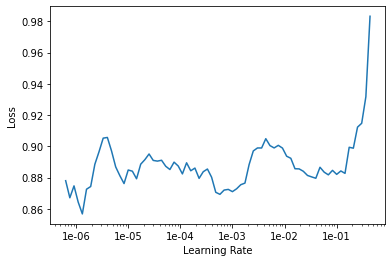

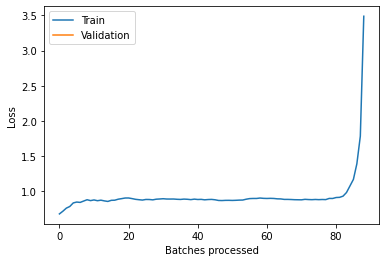

In [72]:
learn.recorder.plot()
learn.recorder.plot_losses()

In [73]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(5e-3/2, 1e-5))
learn.freeze()
learn.save('step-3')

epoch,train_loss,valid_loss,accuracy,time
0,0.850758,0.841324,0.652000,00:57


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


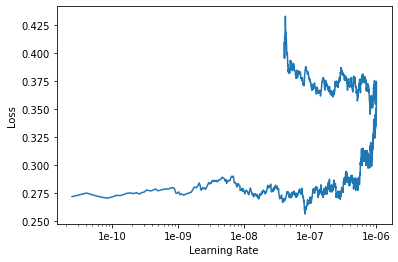

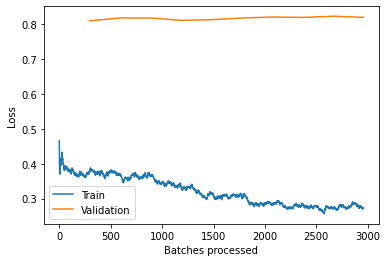

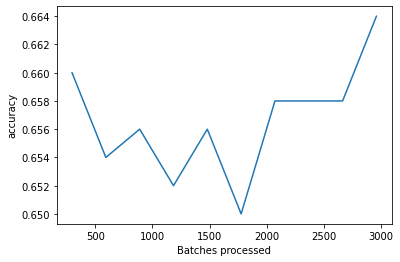

In [ ]:
learn.recorder.plot()
learn.recorder.plot_losses()

In [74]:
learn.export()

In [77]:
%%time
predict = []
predP = []
for description in tqdm_notebook(test_df.description):
    predicts = learn.predict(description)
    predict.append(int(predicts[1]))
    predP.append(np.array(predicts[2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
predP = pd.DataFrame(predP)
predP.columns = data_clas.classes
predP.to_csv('.csv', index=False)
predP.head()

In [ ]:
!cp /content/drive/'My Drive'/kaggle/kaggle.json /root/.kaggle
!kaggle competitions download -c digit-recognizer

from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive/kaggle")

cp: cannot stat '/content/drive/My Drive/kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
Test_id = test_df['id']

In [ ]:
genre_sub=[]
for i in predict:
    genre_sub.append(data_clas.classes[i])

submission = pd.concat([Test_id, pd.DataFrame(genre_sub)], axis=1)
submission.columns = ['id','genre']
submission.to_csv('submission_LSTM.csv', index=False)
submission.head()

,id,genre
0,14626,comedy
1,11338,drama
2,15465,comedy
3,13496,documentary
4,13912,documentary
